Creator: Yen Ting Lin, CCS-3, LANL 

Note: For the manuscript "*Gene expression noise accelerates the evolution of a biological oscillator*", co-authored by Nicolas E. Buchler, NCSU

The code has been reviewed by Richard P. Feynman Center for Innovation at the Los Alamos National Laboratory, with a C number C21109

This notebook simulates the evolutionary processes of two biophysical parameters $\beta^F_X$ and $\beta^B_X$ for deterministic gene expression dynamics.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
from matplotlib import cm 

from multiprocessing import Pool
from subprocess import call, STDOUT

from scipy import signal
from scipy.stats import norm, uniform, multivariate_normal

In [2]:
plt.rcParams.update({'font.size':14})

In [3]:
initial2Dlocations = np.array([
    [9 , 165],
    [7 , 210],
    [6.5 , 260],
    [9 , 310],
    [20, 165],
    [20, 300],
    [25, 210],
    [25, 260],
])

In [4]:
mutationCovDiag = 0.01*np.array([1.0, 40])

In [5]:
rep = 1 # Replica index. For the paper, we ran 5 replica and made sure the observations are robust 
globalIndex = 0

In [6]:
populationN = 100
poolN = populationN
tSpan = np.linspace(0,50,10001)

In [7]:
par = {'kappaX':1.2,
       'kappaY':0.9,
       'theta':1,
       'nA':3,
       'nB':3,
       'alpha':10,
       'betaBX':200,
       'betaFX':12,
       'betaBY':400,
       'betaFY':10,
       'deltaX':1.,
       'deltaY':0.05,}

def H(x,kappa,theta,N):
    
    prob=np.ones([1,N+1])
    
    for i in range(1,N+1):
        prob[0,i] = prob[0,i-1] * kappa * x  / theta 
    
    total=0
    
    for i in range(N+1):
        total += prob[0,i]
    
    return prob[0][N]/total


def RHS(t,z,par):
    
    x,y  = z
    
    dxdt =  par['betaFX'] + (par['betaBX']-par['betaFX'])*H(x,par['kappaX'],par['theta'],3)-par['deltaX']*x - par['alpha']*x*y
    dydt =  par['betaFY'] + (par['betaBY']-par['betaFY'])*H(x,par['kappaY'],par['theta'],3)-par['deltaY']*y - par['alpha']*x*y
    
    return np.array([dxdt,dydt])



In [8]:
def compileParList(par):
    
    populationN = len(par)
    
    parList = np.zeros((populationN, 3))
    
    parList[:,0] = range(populationN)
    parList[:,1:] = par[:,:]
    
    return parList

In [9]:
def batchRun(parList,tSpan):
    
    tN = len(tSpan)
    populationN = len(parList)
    
    output = np.zeros((populationN, tN))
    
    counter = 0
    
    for _,betaFX,betaBX in parList:
        
        par['betaFX'] = betaFX
        par['betaBX'] = betaBX

        sol =  solve_ivp(fun=lambda t,z: RHS(t,z,par), t_span=(tSpan[0],tSpan[-1]), y0=(0.0,0.0), t_eval=tSpan, method='LSODA', rtol=1e-5, atol=1e-5)
        
        output[counter, :]  = sol.y[0,:]
        
        counter += 1

    return output

In [10]:
def evaluatePeak(solutions,dt):
    
    output = []
    
    output_fullPSD = []
    
    populationN = len(solutions)
    
    for i in range(populationN):
    
        data = solutions[i,:]
        x=data[5000:]

        x=(x-np.mean(x))
        fs = 1/dt
        freqTemp, psdTemp = signal.welch(x, fs, nperseg=256, nfft=len(x), window='boxcar', noverlap=0)

        maxDensity = np.amax(psdTemp)
        index = np.where(psdTemp==maxDensity)[0][0]
        maxFrequency = freqTemp[index]
        
        if maxDensity < 1E-4:
            
            maxDensity = 0    
            maxFrequency = 0
            
        output.append([maxFrequency, maxDensity])
        
        output_fullPSD.append(np.vstack((freqTemp, psdTemp)))

    return np.array(output),  np.array(output_fullPSD)

In [11]:
def evaluateFitness(parList,tSpan):
    
    populationN = len(parList)
    
    solutions = batchRun(parList,tSpan)
    
    l,_ = evaluatePeak(solutions, tSpan[1]-tSpan[0])
    
    # combine peak frequency and peak power
    targetF = 1.5

    C0 = 0
    C1 = 1
    
    return l[:,1]/(1+l[:,1])/(1+(l[:,0]-targetF)**2)

In [12]:
def generate2DMutation(par,size):
   
    if len(par.shape)==1:
        
        # single parameter set
        
        return multivariate_normal(mean=par, cov=np.diag(mutationCovDiag)).rvs(size)
        
    elif len(par.shape)==2:
        
        NN,MM = par.shape
        output = np.zeros([size, MM])
        
        for i in range(size):
            
            output[i,:] = multivariate_normal(mean=par[np.random.choice(NN),:], cov=np.diag(mutationCovDiag)).rvs(1)
            
        return output

In [13]:
def selectionMutation(parList,tSpan):
    
    populationN = len(parList)
    
    selectionPercentage = 10.
    
    selectedN = np.around(populationN*(selectionPercentage/100)).astype('int64')
    
    # Evaluate the fitness
    f = evaluateFitness(parList,tSpan)

    # Order and select
    selectedIndex = f.argsort()[::-1][:selectedN]

    # select
    selectedPar = parList[selectedIndex,1:]
    
    # mutation kernel
    
    newParList = np.zeros((populationN, parList.shape[1]))

    newParList[:,0] = range(populationN)
    newParList[:,1:] = generate2DMutation(selectedPar,populationN)
    
    return newParList,f
    
    

In [14]:
# generate N paths
pathN = len(initial2Dlocations)

tN = 200

summary = np.zeros([1+initial2Dlocations.shape[1], pathN, tN, populationN])

ifContinue = False

if ifContinue:
    
        
    previousSummary = np.load('20210929-full2DevolutionLog-det-correctedCov-rep'+str(rep)+'.npz')['summary']

    T = previousSummary.shape[2]

    summary = np.zeros([1+initial2Dlocations.shape[1], pathN, T+tN, populationN])

    
else:

    T = 0

        
for pp in range(pathN):

    if ifContinue:
        
        for i in range(T):
            
            summary[:,:,i,:] = previousSummary[:,:,i,:]
        
            initialPar = previousSummary[:-1,pp,-1,:].T
            
    else:
        
        initialPar = generate2DMutation(initial2Dlocations[pp,:],populationN)
        
    parList = compileParList(initialPar)
    
    for tt in range(T,T+tN):

        parList,fitness = selectionMutation(parList,tSpan)
        
        summary[:-1, pp, tt, :] = parList[:,1:].T
        summary[-1, pp, tt, :] = fitness[:]
        
        print('Path='+str(pp)+', iteration '+ str(tt) + ', location=' + str(np.mean(parList[:,1:] ,axis=0)), flush=True)

Path=0, iteration 0, location=[  9.0271146  165.35070744]
Path=0, iteration 1, location=[  8.97655593 165.30525135]
Path=0, iteration 2, location=[  9.10384652 165.05945896]
Path=0, iteration 3, location=[  9.11659375 164.27916753]
Path=0, iteration 4, location=[  9.09910362 164.02389987]
Path=0, iteration 5, location=[  9.07118934 163.87015016]
Path=0, iteration 6, location=[  9.04256697 163.9616941 ]
Path=0, iteration 7, location=[  8.91585585 163.39030291]
Path=0, iteration 8, location=[  8.92768469 162.92941181]
Path=0, iteration 9, location=[  8.84093506 162.26822382]
Path=0, iteration 10, location=[  8.88479254 162.9727977 ]
Path=0, iteration 11, location=[  8.76439872 161.90698186]
Path=0, iteration 12, location=[  8.7022517  162.16826218]
Path=0, iteration 13, location=[  8.6390099  162.82048663]
Path=0, iteration 14, location=[  8.59927415 163.01065147]
Path=0, iteration 15, location=[  8.65021272 162.82850314]
Path=0, iteration 16, location=[  8.56539174 160.73015511]
Path=0,

Path=0, iteration 139, location=[  9.61544974 161.266655  ]
Path=0, iteration 140, location=[  9.75055731 161.74426924]
Path=0, iteration 141, location=[  9.85926106 161.46889175]
Path=0, iteration 142, location=[  9.80720696 160.80527568]
Path=0, iteration 143, location=[  9.58003554 160.54792573]
Path=0, iteration 144, location=[  9.53829633 160.98169635]
Path=0, iteration 145, location=[  9.43745723 161.78751225]
Path=0, iteration 146, location=[  9.52533625 162.07921156]
Path=0, iteration 147, location=[  9.44374723 162.19523418]
Path=0, iteration 148, location=[  9.42744799 162.24794441]
Path=0, iteration 149, location=[  9.43013109 162.14552793]
Path=0, iteration 150, location=[  9.46126627 161.92883622]
Path=0, iteration 151, location=[  9.37577186 161.24561059]
Path=0, iteration 152, location=[  9.33478916 161.21160052]
Path=0, iteration 153, location=[  9.30810206 161.64433289]
Path=0, iteration 154, location=[  9.33617604 161.83188183]
Path=0, iteration 155, location=[  9.361

Path=1, iteration 79, location=[  7.53150356 205.86071458]
Path=1, iteration 80, location=[  7.41614028 205.62735236]
Path=1, iteration 81, location=[  7.45372374 204.68413732]
Path=1, iteration 82, location=[  7.39947678 205.54000726]
Path=1, iteration 83, location=[  7.3579966  205.83995045]
Path=1, iteration 84, location=[  7.40882309 206.59896331]
Path=1, iteration 85, location=[  7.37715659 207.43121397]
Path=1, iteration 86, location=[  7.21865999 207.43098082]
Path=1, iteration 87, location=[  7.2672393  209.70450099]
Path=1, iteration 88, location=[  7.22978946 208.28006721]
Path=1, iteration 89, location=[  7.27991191 208.94302008]
Path=1, iteration 90, location=[  7.2193955  207.94322927]
Path=1, iteration 91, location=[  7.15640291 206.66078286]
Path=1, iteration 92, location=[  7.14416263 206.24217355]
Path=1, iteration 93, location=[  7.22853612 203.95902026]
Path=1, iteration 94, location=[  7.34103006 203.15373567]
Path=1, iteration 95, location=[  7.3958914  204.6251284

Path=2, iteration 17, location=[  6.26879555 261.23247939]
Path=2, iteration 18, location=[  6.31743586 261.4907632 ]
Path=2, iteration 19, location=[  6.35215496 261.84749677]
Path=2, iteration 20, location=[  6.26939564 261.09894775]
Path=2, iteration 21, location=[  6.27655818 261.0804136 ]
Path=2, iteration 22, location=[  6.36781249 261.59664611]
Path=2, iteration 23, location=[  6.4410775  262.15847284]
Path=2, iteration 24, location=[  6.41453246 262.55175051]
Path=2, iteration 25, location=[  6.42080625 262.07633526]
Path=2, iteration 26, location=[  6.4951619 261.8830255]
Path=2, iteration 27, location=[  6.45813045 261.80311108]
Path=2, iteration 28, location=[  6.5000805  262.21976178]
Path=2, iteration 29, location=[  6.49493418 261.74218527]
Path=2, iteration 30, location=[  6.46668041 260.25028754]
Path=2, iteration 31, location=[  6.43958482 260.12867597]
Path=2, iteration 32, location=[  6.34124181 259.67403829]
Path=2, iteration 33, location=[  6.33309028 259.5952503 ]

Path=2, iteration 155, location=[  4.48927544 265.23268251]
Path=2, iteration 156, location=[  4.53537518 265.24622491]
Path=2, iteration 157, location=[  4.50369893 265.60315814]
Path=2, iteration 158, location=[  4.41312863 265.68484041]
Path=2, iteration 159, location=[  4.31770864 265.27748394]
Path=2, iteration 160, location=[  4.29331132 266.16006106]
Path=2, iteration 161, location=[  4.23324924 265.24431935]
Path=2, iteration 162, location=[  4.36395748 264.15974141]
Path=2, iteration 163, location=[  4.29289911 262.64685778]
Path=2, iteration 164, location=[  4.33583552 261.46191612]
Path=2, iteration 165, location=[  4.45825148 261.90080753]
Path=2, iteration 166, location=[  4.46432716 262.07969694]
Path=2, iteration 167, location=[  4.57672854 262.14857207]
Path=2, iteration 168, location=[  4.49053021 262.43158768]
Path=2, iteration 169, location=[  4.40039288 262.16209518]
Path=2, iteration 170, location=[  4.35308548 262.50296272]
Path=2, iteration 171, location=[  4.352

Path=3, iteration 94, location=[  9.23730249 317.80219875]
Path=3, iteration 95, location=[  9.35928787 318.46739999]
Path=3, iteration 96, location=[  9.41543259 318.75181543]
Path=3, iteration 97, location=[  9.62689224 318.84945742]
Path=3, iteration 98, location=[  9.34915406 318.23327625]
Path=3, iteration 99, location=[  9.54937064 318.39448937]
Path=3, iteration 100, location=[  9.31438921 317.66415757]
Path=3, iteration 101, location=[  9.31601898 317.27704564]
Path=3, iteration 102, location=[  9.39818309 318.02337964]
Path=3, iteration 103, location=[  9.39827848 318.26293547]
Path=3, iteration 104, location=[  9.55285464 319.89075396]
Path=3, iteration 105, location=[  9.51697023 320.29300976]
Path=3, iteration 106, location=[  9.49030134 320.81645242]
Path=3, iteration 107, location=[  9.36945346 320.48445205]
Path=3, iteration 108, location=[  9.27087639 320.07429568]
Path=3, iteration 109, location=[  9.17594772 320.10543244]
Path=3, iteration 110, location=[  9.13417975 

Path=4, iteration 32, location=[ 20.72771877 165.37532128]
Path=4, iteration 33, location=[ 20.64776607 165.07893223]
Path=4, iteration 34, location=[ 20.80224706 165.70466366]
Path=4, iteration 35, location=[ 20.75631553 165.1722534 ]
Path=4, iteration 36, location=[ 20.69390099 164.90389574]
Path=4, iteration 37, location=[ 20.63792227 164.2525791 ]
Path=4, iteration 38, location=[ 20.61197255 164.67955325]
Path=4, iteration 39, location=[ 20.70812767 164.78106431]
Path=4, iteration 40, location=[ 20.74680528 165.25462342]
Path=4, iteration 41, location=[ 20.85969647 166.05300449]
Path=4, iteration 42, location=[ 20.9080734  165.68456216]
Path=4, iteration 43, location=[ 20.88168459 165.73841602]
Path=4, iteration 44, location=[ 20.82460108 164.97677091]
Path=4, iteration 45, location=[ 20.68751234 164.09943058]
Path=4, iteration 46, location=[ 20.77297935 164.52308153]
Path=4, iteration 47, location=[ 20.61090469 163.29826308]
Path=4, iteration 48, location=[ 20.63840203 163.5643399

Path=4, iteration 170, location=[ 21.58655772 182.2090638 ]
Path=4, iteration 171, location=[ 21.64903179 179.30971801]
Path=4, iteration 172, location=[ 21.69907318 179.48602375]
Path=4, iteration 173, location=[ 21.81052947 178.98988273]
Path=4, iteration 174, location=[ 21.85189208 178.83504566]
Path=4, iteration 175, location=[ 21.82775387 179.04931761]
Path=4, iteration 176, location=[ 21.84610237 179.98839671]
Path=4, iteration 177, location=[ 21.81532412 178.71922786]
Path=4, iteration 178, location=[ 21.86435309 176.3635561 ]
Path=4, iteration 179, location=[ 21.69972546 176.87979552]
Path=4, iteration 180, location=[ 21.60794241 178.56559137]
Path=4, iteration 181, location=[ 21.58121672 176.71687572]
Path=4, iteration 182, location=[ 21.44328747 176.04798525]
Path=4, iteration 183, location=[ 21.32943044 175.81524623]
Path=4, iteration 184, location=[ 21.47440703 175.32693594]
Path=4, iteration 185, location=[ 21.40045288 175.45517001]
Path=4, iteration 186, location=[ 21.224

Path=5, iteration 109, location=[ 19.01664353 299.05451924]
Path=5, iteration 110, location=[ 19.02164281 298.21773138]
Path=5, iteration 111, location=[ 18.96851256 297.0642408 ]
Path=5, iteration 112, location=[ 19.02321584 297.27416037]
Path=5, iteration 113, location=[ 18.93079589 297.48432414]
Path=5, iteration 114, location=[ 19.03335803 297.59282682]
Path=5, iteration 115, location=[ 18.99373887 297.346949  ]
Path=5, iteration 116, location=[ 18.97599363 297.73224984]
Path=5, iteration 117, location=[ 19.1346618  297.57624345]
Path=5, iteration 118, location=[ 19.00501044 297.89067792]
Path=5, iteration 119, location=[ 19.0173473  298.03462693]
Path=5, iteration 120, location=[ 19.05597163 297.54892034]
Path=5, iteration 121, location=[ 19.11630952 297.48406159]
Path=5, iteration 122, location=[ 18.95280062 298.06927217]
Path=5, iteration 123, location=[ 18.88170846 298.78494766]
Path=5, iteration 124, location=[ 18.7465087  297.91061147]
Path=5, iteration 125, location=[ 18.653

Path=6, iteration 47, location=[ 25.6906578  211.99644098]
Path=6, iteration 48, location=[ 25.69472707 212.07391887]
Path=6, iteration 49, location=[ 25.77529792 211.48020334]
Path=6, iteration 50, location=[ 25.8477369  210.55849134]
Path=6, iteration 51, location=[ 25.8457146  210.69504173]
Path=6, iteration 52, location=[ 25.80307723 210.2094867 ]
Path=6, iteration 53, location=[ 25.78480085 210.00193541]
Path=6, iteration 54, location=[ 25.73286764 210.36374648]
Path=6, iteration 55, location=[ 25.76929079 210.64035894]
Path=6, iteration 56, location=[ 25.69583945 211.35536419]
Path=6, iteration 57, location=[ 25.87782944 210.7715317 ]
Path=6, iteration 58, location=[ 25.92901606 210.34638161]
Path=6, iteration 59, location=[ 25.98607244 210.68785999]
Path=6, iteration 60, location=[ 26.09142334 210.56537051]
Path=6, iteration 61, location=[ 26.07017238 210.97102981]
Path=6, iteration 62, location=[ 26.0485017 211.69603  ]
Path=6, iteration 63, location=[ 25.95629356 211.97465366]

Path=6, iteration 185, location=[ 25.64940988 208.65908276]
Path=6, iteration 186, location=[ 25.49972197 208.74069533]
Path=6, iteration 187, location=[ 25.48266944 208.3168052 ]
Path=6, iteration 188, location=[ 25.4984204 208.6422443]
Path=6, iteration 189, location=[ 25.41308208 209.31071202]
Path=6, iteration 190, location=[ 25.34376163 207.92067234]
Path=6, iteration 191, location=[ 25.17574871 207.01903299]
Path=6, iteration 192, location=[ 25.16951001 206.52084736]
Path=6, iteration 193, location=[ 25.02894527 206.0075583 ]
Path=6, iteration 194, location=[ 25.16418305 205.15705595]
Path=6, iteration 195, location=[ 25.19521063 205.69890333]
Path=6, iteration 196, location=[ 25.26475751 206.32520723]
Path=6, iteration 197, location=[ 25.22669216 206.07086411]
Path=6, iteration 198, location=[ 25.30944957 205.78577067]
Path=6, iteration 199, location=[ 25.26047743 206.50185309]
Path=7, iteration 0, location=[ 25.04326169 259.89486874]
Path=7, iteration 1, location=[ 25.10778606 

Path=7, iteration 124, location=[ 26.3558198  258.99970065]
Path=7, iteration 125, location=[ 26.35459321 258.71184744]
Path=7, iteration 126, location=[ 26.34675923 259.01416032]
Path=7, iteration 127, location=[ 26.26733    259.00078361]
Path=7, iteration 128, location=[ 26.5424279  258.67645608]
Path=7, iteration 129, location=[ 26.45274296 259.24250766]
Path=7, iteration 130, location=[ 26.58903644 258.77924021]
Path=7, iteration 131, location=[ 26.81767249 259.22789609]
Path=7, iteration 132, location=[ 26.58587511 259.45039358]
Path=7, iteration 133, location=[ 26.99605475 259.10293635]
Path=7, iteration 134, location=[ 26.90980262 259.68817559]
Path=7, iteration 135, location=[ 26.39048819 260.04944984]
Path=7, iteration 136, location=[ 26.65870548 259.86532346]
Path=7, iteration 137, location=[ 27.20845703 259.34227345]
Path=7, iteration 138, location=[ 27.37104218 258.98699315]
Path=7, iteration 139, location=[ 27.30644139 258.21655966]
Path=7, iteration 140, location=[ 27.311

# Save

In [15]:
np.savez('20210929-full2DevolutionLog-det-correctedCov-rep'+str(rep), summary=summary)

# Visualize

In [16]:
dimFX = 301
dimBX = 301

betaFXgrid = np.linspace(5, 30, 301)
betaBXgrid = np.linspace(150, 320, 301)

betaBXgrid,betaFXgrid = np.meshgrid(betaBXgrid,betaFXgrid)

dataSto = np.load('stoLandscape.npz', allow_pickle=True)['fullOutput']
dataDet = np.load('detLandscape.npz', allow_pickle=True)['fullOutput']

betaFXmin = np.amin(dataSto[:,0])
betaFXmax = np.amax(dataSto[:,0])
betaBXmin = np.amin(dataSto[:,1])
betaBXmax = np.amax(dataSto[:,1])

PSDsto = np.reshape(dataSto[:,-1], [dimFX,dimBX])
PSDdet = np.reshape(dataDet[:,-1], [dimFX,dimBX])

Text(0, 0.5, '$\\beta^F_X$')

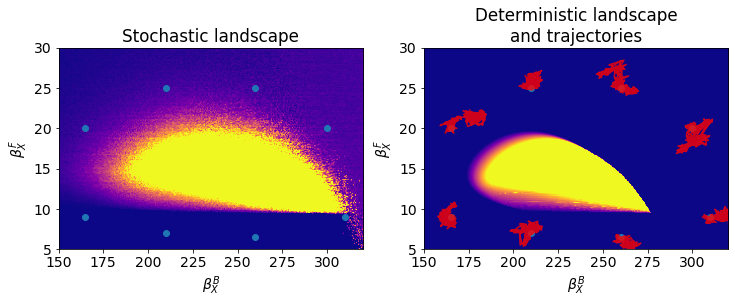

In [21]:
fig = plt.figure(figsize=(12, 5))

ax = [plt.subplot(1,2,i+1) for i in range(2)]

im = ['','']
im[0] = ax[0].imshow(PSDsto, extent=[betaBXmin, betaBXmax, betaFXmin, betaFXmax,], origin='lower', cmap=cm.plasma, aspect=4.5, vmax=0.025)
im[1] = ax[1].imshow(PSDdet, extent=[betaBXmin, betaBXmax, betaFXmin, betaFXmax,], origin='lower', cmap=cm.plasma, aspect=4.5, vmax=0.025)

ax[0].scatter(initial2Dlocations[:,1], initial2Dlocations[:,0])
ax[1].scatter(initial2Dlocations[:,1], initial2Dlocations[:,0])

for i in range(initial2Dlocations.shape[0]):
    
    ax[1].plot( summary[1, i, :, 1], summary[0, i, :, 1], color='r', alpha=0.8)
    
ax[1].set_xlim([betaBXmin, betaBXmax])
ax[1].set_ylim([betaFXmin, betaFXmax])

ax[0].set_title('Stochastic landscape')
ax[1].set_title('Deterministic landscape\nand trajectories')

ax[0].set_xlabel('$\\beta^B_X$')
ax[0].set_ylabel('$\\beta^F_X$')

ax[1].set_xlabel('$\\beta^B_X$')
ax[1].set_ylabel('$\\beta^F_X$')
